# Import Packages

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from tensorflow.keras.utils import to_categorical

In [2]:
#-- Dataset loader --#

def fetch_images(path, label=None, image_ext='jpg'):
    image_names = [x for x in os.listdir(path) if x.split('.')[-1] in image_ext]
    if len(image_names) == 0: raise Exception('No files found')
    bga_images = [cv2.imread(path + '/' + img) for img in  image_names]
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in bga_images]
    return images, [[label, image_names[i]] for i in range(len(images))]

def fetch_dataset(path, image_ext=['jpg','png']):
    # Get all folders in the path var
    all_folders = [fol for fol in os.listdir(path)]
    # Get only subfolders that contains files with image_ext
    folders = [fol for fol in all_folders if len([x for x in os.listdir(path + '/' + fol) if x.split('.')[-1] in image_ext]) > 0]
    # Throw error if no files are found
    if len(folders) == 0: raise Exception('No files found')
    print(f'Found the following folders: {folders}')
    data_list, label_list = [], []
    for folder in folders:
        data, label = fetch_images(path + '/' + folder, folder, image_ext)
        data_list = data_list + data
        label_list = label_list + label
    return data_list, label_list


#-- Data Processer --#

def center_crop_image(img):
    h, w = img.shape[:2]
    aspect = h/w
    if aspect > 1:
        offset = int(np.round((h / 2) - (w / 2)))
        return img[offset:w + offset, 0:w]
    else:
        offset = int(np.round((w / 2) - (h / 2)))
        return img[0:h, offset:h + offset]

def process_images(images, image_size):
    cropped_images = [center_crop_image(img) for img in images]
    resized_images = [cv2.resize(img, (image_size, image_size), cv2.INTER_AREA) for img in cropped_images]
    return resized_images


#-- Data visualizer --#

def visualizer(x, y=None, grid=None, font=None):
    if not font:
        font = {'font.family': 'Arial', 'font.size' : 12}
    rcParams.update(font)
    if not grid or 1 in grid:
        fig = plt.figure(figsize=(6,6))
        plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        plt.imshow(x, cmap="Greys")
        if y: plt.title(y)
    else:
        fig, axes = plt.subplots(grid[0], grid[1],figsize=(10,10))
        for row in axes:
            for axe in row:
                axe.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
                r = np.random.randint(len(x))
                axe.imshow(x[r], cmap="Greys")
                if y: axe.set_title(y[r])
                #plt.tight_layout()
    plt.show()

# Load dataset

In [3]:
data, label = fetch_dataset('dataset/Combined')

Found the following folders: ['Mask', 'No Mask']


In [4]:
image_size = 96
data = process_images(data, image_size)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=0)

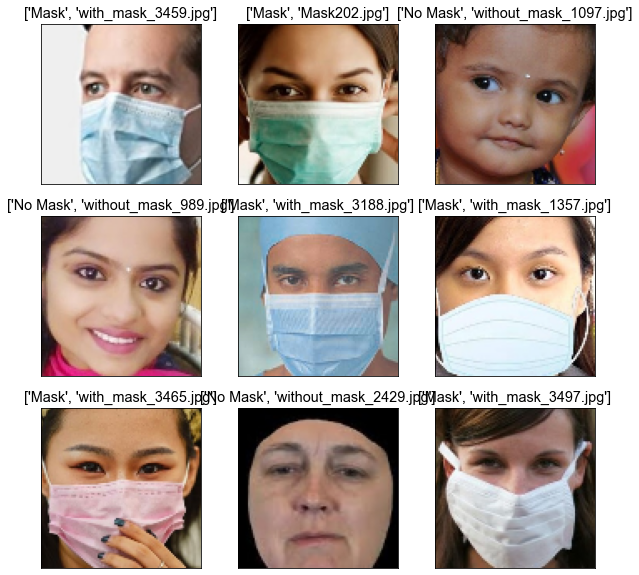

In [6]:
visualizer(X_train, y_train, grid=(3,3))

In [7]:
# Reshape X
X_train = np.array(X_train).reshape(-1, image_size, image_size, 3)
X_test = np.array(X_test).reshape(-1, image_size, image_size, 3)

# Categorize y
y_train = np.array([0 if val[0]=='Mask' else 1 if val[0]=='No Mask' else val for val in y_train])
y_test = np.array([0 if val[0]=='Mask' else 1 if val[0]=='No Mask' else val for val in y_test])


# encode the y labels
y_train, y_test = to_categorical(y_train, 2), to_categorical(y_test, 2)

# CNN

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation

model = Sequential()
model.add(MobileNetV2(input_shape=(image_size, image_size, 3), classes=2, include_top=False))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 23042     
_________________________________________________________________
activation (Activation)      (None, 2)                 0         
Total params: 2,281,026
Trainable params: 2,246,914
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
27/27 [==============================] - 9s 98ms/step - loss: 0.2338 - accuracy: 0.9469
Epoch 2/20
27/27 [==============================] - 2s 75ms/step - loss: 0.1958 - accuracy: 0.9717
Epoch 3/20
27/27 [==============================] - 2s 75ms/step - loss: 0.0574 - accuracy: 0.9906
Epoch 4/20
27/27 [==============================] - 2s 75ms/step - loss: 0.0107 - accuracy: 0.9976
Epoch 5/20
27/27 [==============================] - 2s 77ms/step - loss: 6.5647e-04 - accuracy: 1.0000
Epoch 6/20
27/27 [==============================] - 2s 75ms/step - loss: 7.7885e-05 - accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 2s 75ms/step - loss: 1.4949e-04 - accuracy: 1.0000
Epoch 8/20
27/27 [==============================] - 2s 75ms/step - loss: 4.9387e-04 - accuracy: 1.0000
Epoch 9/20
27/27 [==============================] - 2s 76ms/step - loss: 2.8871e-05 - accuracy: 1.0000
Epoch 10/20
27/27 [==============================] - 2s 76ms/step - loss: 4.0958e-05 - ac

In [10]:
(_, eval_accuracy) = model.evaluate(X_test, y_test, verbose=2)

12/12 - 1s - loss: 0.7017 - accuracy: 0.9807


In [11]:
model.save('model')

C:\tools\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
